<a href="https://colab.research.google.com/github/lphansen/RiskUncertaintyValue/blob/main/expansion_suite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertain Expansion Example Notebook

# 1 Preliminaries <a class="anchor" id="s2"></a>

## 1.1 Model Setup
$$
\begin{align}
X_{t+1} \left( \mathsf{q} \right) =  & \hspace{.2cm} \psi^x \left[D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q} \right), {\sf q} W_{t+1}, {\sf q} \right], \cr
\log G_{t+1} \left( \mathsf{q} \right) - \log G_t \left( \mathsf{q} \right) = & \hspace{.2cm} \psi^g \left[ D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q},
 \right), {\sf q} W_{t+1}, {\sf q}  \right], \cr
{\widehat C}_t \left( \mathsf{q} \right)  = & \hspace{.2cm} \kappa \left[D_t \left( \mathsf{q} \right), X_{t} \left( \mathsf{q}  \right) \right] + {\widehat G}_t \left( \mathsf{q} \right).
\end{align}
$$

In addition, there are a set of first-order conditions and co-state equations detailed in Chapter 8 of the book. These are compiled automatically by the code.


## 1.2 Inputs

The `Expansion Suite` uses the function `uncertain_expansion` to approximate a solution to the above system locally. The user must specify several sets of inputs. Define the relevant variables:

```{list-table}
* - Input
  - Description
  - Notation in text
* - `control_variables`
  - Variables chosen by the decision-maker at time $t$
  - $D_t$
* - `state_variables`
  - Variables that describe the current state of the system
  - $X_t$
* - `shock_variables`
  - Variables representing different entries of the Brownian motion variable
  - $W_t$
```

The $t+1$ variables will be automatically created from this. For example, if a state variable is inputted as `Z_t`, an additional state variable `Z_tp1` will be automatically generated. 
We also need to define the equilibrium conditions:

```{list-table}
* - Input
  - Description
  - Notation in text
* - `kappa`
  - Log share of capital not allocated to consumption
  - $\kappa(X_t(q),D_t(q))$
* - `growth`
  - Law of motion for $\hat{G}_{t+1}-\hat{G}_t$
  - $\psi^g(D_t(q),X_t(q),qW_{t+1},q)$
* - `state_equations`
  - Law of motion for state variables
  - $\psi^x(D_t(q),X_t(q),qW_{t+1},q)$
```

The remaining equilibrium conditions will be automatically computed by the code. The user must also define a list of parameters and their corresponding values. This can be done by specifying pairs of inputs such as `beta = 0.99` or `gamma = 1.01` within the body of the function `create_args`. 

Note that the user must define the variables and parameters *before* defining the equations. Make sure that the **equations use the same expressions for variables and parameters** as previously defined by the user. 

The output is of class `ModelSolution`, which stores the coefficients for the linear-quadratic approximation for the jump and state variables; continuation values; consumption growth; and log change of measure, as well as the steady-state values of each variables. 


<br>

# 2 Example
We will now walk through the computation using the example above. Begin by installing the following libraries and downloading `RiskUncertaintyValue`, which contains the functions required to solve the model:

In [1]:
import os
import sys
import sympy as sp
workdir = os.getcwd()
# !git clone https://github.com/lphansen/RiskUncertaintyValue 
workdir = os.getcwd() + '/RiskUncertaintyValue'             
sys.path.insert(0, workdir+'/src')                        
import numpy as np
import seaborn as sns
import autograd.numpy as anp
from scipy import optimize
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=200)
from IPython.display import display, HTML
from BY_example_sol import disp
display(HTML("<style>.container { width:97% !important; }</style>"))
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.stats import norm

from lin_quad import LinQuadVar
from lin_quad_util import E, concat, next_period, cal_E_ww, lq_sum, N_tilde_measure, E_N_tp1, log_E_exp, kron_prod, distance
from utilities import mat, vec, sym
from uncertain_expansion import uncertain_expansion, generate_symbols_and_args, compile_equations, get_parameter_value, \
    generate_ss_function, automate_step_1, change_parameter_value
from elasticity import exposure_elasticity, price_elasticity
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
import pickle
import pandas as pd
from scipy.optimize import fsolve
# import sympy as sp

## 2.1 Parameters
Use the following function to define and set the values for your parameters.

In [2]:
def create_args():
    # Define parameters here
    sigma_k1 = 0.92 * anp.sqrt(3)
    sigma_k2 = 0.4 * anp.sqrt(3)
    sigma_k3 = 0.0
    sigma_z1 = 0.0
    sigma_z2 = 5.7 * anp.sqrt(3)
    sigma_z3 = 0.0
    sigma_y1 = 0.0
    sigma_y2 = 0.0
    sigma_y3 = 0.00031 * anp.sqrt(3)
    
    # Base parameters
    delta = 0.01/4
    a = 0.0922
    epsilon = 1.0
    gamma = 1.001                        #Do not change this name
    rho = 1.001                            #Do not change this name
    beta = anp.exp(-epsilon * delta)     #Do not change this name
    
    # Capital evolution parameters
    phi_1 = 1 / 8 /4
    phi_2 = 8.0
    beta_k = 0.04 /4
    alpha_k = 0.04 /4
    
    # Other states
    beta_z = 0.056 /4
    beta_2 = 0.194 /4
    mu_2 = 6.3 * (10**(-6))
    
    # Return as a dictionary
    return locals()



## 2.2 Variables
Define your variables as below. You may only have one growth variable and one perturbation variable. Apart from this, you may add more variables to the list as you wish.

Control variable : $i = \frac{I_{k,t}}{K_t}$

State variable: $X = [Z_1, Z_2]$

In [3]:
# Define variable names
control_variables = ["imk_t"]
state_variables = ["Z_t", "Y_t"]
growth_variables = ["log_gk_t"]
perturbation_variable = ["q_t"]
shock_variables = ["W1_t", "W2_t", "W3_t"]

The user does not need to change the following code, which creates symbols for the defined parameters and variables. 

In [4]:
parameter_names, args = generate_symbols_and_args(create_args)
globals().update(parameter_names)
variables = control_variables + state_variables + growth_variables + perturbation_variable + shock_variables
variables_tp1 = [var + "p1" for var in variables]
symbols = {var: sp.Symbol(var) for var in variables + variables_tp1}
globals().update(symbols)  

## 2.3 Define Equilibrium Conditions
Ensure that you use the same names for your variables and parameters from before. You must have one output constraint and one capital growth equation, but you may add as many state equations as you wish. The first-order conditions and co-state equations will be automatically handled and do not need to be specified.

State variables, growth variable and consumption-capital ratio:

$$
X_t = [Z_1, Z_2]\\
\hat G = \log K\\
\hat C_t - \hat G_t = \kappa(D_t, X_t)
$$

The evolution equations:

$$
\begin{aligned}
X_{t+1} =& \psi^x (D_t(q), X_t(q), qW_{t+1}, q) \\
\hat G_{t+1} - \hat G_{t} =& \psi^g (D_t(q), X_t(q), qW_{t+1}, q)\\
\kappa(D_t, X_t) =& \log{\alpha-D_t}
\end{aligned}
$$

In [5]:
# Output constraint
kappa = sp.log(a - imk_t)

# Capital growth equation
growth = epsilon * (phi_1 * sp.log(1. + phi_2 * imk_t) - alpha_k + beta_k * Z_t \
                      - q_t**2 * 0.5 * (sigma_k1**2 + sigma_k2**2 + sigma_k3**2) * sp.exp(Y_t)) \
                      + sp.sqrt(epsilon) * sp.exp(0.5 * Y_t) * (sigma_k1 * W1_tp1 + sigma_k2 * W2_tp1 + sigma_k3 * W3_tp1)       

# Technology growth equation
technology_growth = Z_t - epsilon * beta_z * Z_t \
                                + sp.sqrt(epsilon) * sp.exp(0.5 * Y_t) * (sigma_z1 * W1_tp1 + sigma_z2 * W2_tp1 + sigma_z3 * W3_tp1)

# Volatility growth equation
volatility_growth = Y_t - epsilon * beta_2 * (1 - mu_2 * sp.exp(-Y_t)) \
                          - q_t**2 * 0.5 * (sigma_y1**2 + sigma_y2**2 + sigma_y3**2) * sp.exp(-Y_t) * epsilon \
                          + sp.exp(-0.5 * Y_t) * (sigma_y1 * W1_tp1 + sigma_y2 * W2_tp1 + sigma_y3 * W3_tp1) * sp.sqrt(epsilon)

# State equations
state_equations = [technology_growth, volatility_growth]


## 2.4 Code Settings
You may additionally set the following:
* **Initial guess** for steady-state variables. This must have the same length as the number of variables
* **Recursive terms initialization**. These are initializations for terms like $\log N_t^*$ and $\hat{R}_t-\hat{V}_t$, which may be loaded from a previous solution.
* **Convergence tolerance**. How small the maximum error across the approximated terms must be before the algorithm is considered to have converged.
* **Maximum iterations**. The maximum number of iterations for the algorithm can take.
* **Save location**. Save the model solution to this location so that it can be accessed later.

The order of the initial guess is as follows:
$$
\left[
    {\widehat V_t} - {\widehat C_t}, \widehat C_t - \widehat K_t, D_t, MX_t, MG_t, \widehat G_{t+1} - \widehat G_t, X_t 
\right]
$$

In [6]:
# Initial guess for the solution: the order is:

initial_guess = np.concatenate([np.array([-2.1968994 ,  -4.123193  ,  anp.exp(-2.57692626)]),np.ones(3),np.array([0.01937842, 0.        , -11.97496092])])

savepath = None
init_util = None
iter_tol = 1e-5
max_iter = 50

#Code for loading pre-solution
# with open(savepath,'rb') as f:
#     preload = pickle.load(f)
# init_util = preload['util_sol']

## 2.5 Run Code
You are now ready to run the function `uncertain_expansion`. You do not need to change anything in the following code.

In [7]:
ModelSol = uncertain_expansion(control_variables, state_variables, shock_variables, variables, variables_tp1,
                            kappa, growth, state_equations, initial_guess, parameter_names,
                            args, approach = '1', init_util = init_util, iter_tol = iter_tol, max_iter = max_iter,
                            savepath=savepath)

[Z_tp1, Y_tp1, log_gk_tp1]
[-sqrt(epsilon)*(W1_tp1*sigma_k1 + W2_tp1*sigma_k2 + W3_tp1*sigma_k3)*exp(0.5*Y_t) - epsilon*(Z_t*beta_k - alpha_k + phi_1*log(imk_t*phi_2 + 1.0) - 0.5*q_t**2*(sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*exp(Y_t)) + log_gk_tp1, Z_t*beta_z*epsilon - Z_t + Z_tp1 - sqrt(epsilon)*(W1_tp1*sigma_z1 + W2_tp1*sigma_z2 + W3_tp1*sigma_z3)*exp(0.5*Y_t), -Y_t + Y_tp1 + beta_2*epsilon*(-mu_2*exp(-Y_t) + 1) - sqrt(epsilon)*(W1_tp1*sigma_y1 + W2_tp1*sigma_y2 + W3_tp1*sigma_y3)*exp(-0.5*Y_t) + 0.5*epsilon*q_t**2*(sigma_y1**2 + sigma_y2**2 + sigma_y3**2)*exp(-Y_t)]
Variable Dictionary:
  vmk_t: -2.1968994
  log_cmk_t: -4.123193
  imk_t: 0.07600727192876003
  m0_t: 1.0
  m1_t: 1.0
  mg_t: 1.0
  log_gk_t: 0.01937842
  Z_t: 0.0
  Y_t: -11.97496092

Substituted Equations:
  Equation 1: 0.0000145154923780911
  Equation 2: 2.20139613205106E-8
  Equation 3: 0.000581045184137569
  Equation 4: -0.00650614261990664
  Equation 5: -0.0508941711674630
  Equation 6: -0.0000145154923780911
  E

You can also run the model solution for different parameters using code like the one displayed below, which loops over values of $\gamma$ and $\lambda$ and saves them to appropriately named outputs:

In [8]:
gamma_values = [1.001, 8.001]
rho_values = [1.001, 1.5]

for gamma_i in gamma_values:
    for llambda_i in rho_values:
        args = change_parameter_value('gamma', parameter_names, args, gamma_i)
        args = change_parameter_value('rho', parameter_names, args, llambda_i)
        output_folder = 'output'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            print(f"Created output folder at: {output_folder}")
        savepath = output_folder+'/single_capital_gamma_{}_rho_{}.pkl'.format(gamma_i, llambda_i)
        uncertain_expansion(control_variables, state_variables, shock_variables, variables, variables_tp1,
                            kappa, growth, state_equations, initial_guess, parameter_names,
                            args, approach = '1', init_util = init_util, iter_tol = iter_tol, max_iter = max_iter,
                            savepath=savepath)
        

[Z_tp1, Y_tp1, log_gk_tp1]
[-sqrt(epsilon)*(W1_tp1*sigma_k1 + W2_tp1*sigma_k2 + W3_tp1*sigma_k3)*exp(0.5*Y_t) - epsilon*(Z_t*beta_k - alpha_k + phi_1*log(imk_t*phi_2 + 1.0) - 0.5*q_t**2*(sigma_k1**2 + sigma_k2**2 + sigma_k3**2)*exp(Y_t)) + log_gk_tp1, Z_t*beta_z*epsilon - Z_t + Z_tp1 - sqrt(epsilon)*(W1_tp1*sigma_z1 + W2_tp1*sigma_z2 + W3_tp1*sigma_z3)*exp(0.5*Y_t), -Y_t + Y_tp1 + beta_2*epsilon*(-mu_2*exp(-Y_t) + 1) - sqrt(epsilon)*(W1_tp1*sigma_y1 + W2_tp1*sigma_y2 + W3_tp1*sigma_y3)*exp(-0.5*Y_t) + 0.5*epsilon*q_t**2*(sigma_y1**2 + sigma_y2**2 + sigma_y3**2)*exp(-Y_t)]
Variable Dictionary:
  vmk_t: -2.1968994
  log_cmk_t: -4.123193
  imk_t: 0.07600727192876003
  m0_t: 1.0
  m1_t: 1.0
  mg_t: 1.0
  log_gk_t: 0.01937842
  Z_t: 0.0
  Y_t: -11.97496092

Substituted Equations:
  Equation 1: 0.0000145154923780911
  Equation 2: 2.20139613205106E-8
  Equation 3: 0.000581045184137569
  Equation 4: -0.00650614261990664
  Equation 5: -0.0508941711674630
  Equation 6: -0.0000145154923780911
  E

Note that the order of the variables listed in the solution is the same as before, except with ${\widehat V_t} - {\widehat C_t}$ removed:

$$
\left[
    \widehat C_t - \widehat K_t, D_t, MX_t, MG_t, \widehat G_{t+1} - \widehat G_t, X_t 
\right]
$$

## 2.6 Plot Elasticities

First, if you did not run the code above, you can load a pre-solved solution by specifying `save_path` as follows:

In [ ]:
save_path = 'output/res.pkl'
with open(save_path, 'rb') as f:
    ModelSol = pickle.load(f)

If you used the loop above, you can also use the following code to load all your solutions dynamically:

In [9]:
models = {}
for gamma_i in gamma_values:
    for rho_i in rho_values:
        save_path = 'output/single_capital_gamma_{}_rho_{}.pkl'.format(gamma_i, rho_i)
        try:
            with open(save_path, 'rb') as f:
                model_key = f"gamma_{gamma_i}_rho_{rho_i}"
                models[model_key] = pickle.load(f)
        except FileNotFoundError:
            print(f"File not found: {save_path}")

We can use `plot_exposure_elasticity_quantiles` to plot exposure elasticities for different shocks.
* `model_list` is a list of solutions you want to use to compute elasticities
* `quantile` specifies the quantiles to be plotted
* `T` specifies the number of periods (using the time-unit that you specified the parameters in)

Additional optional parameters are included for aesthetics.

Here is an example:

In [10]:
def plot_exposure_quantiles(
    model_list, 
    quantile, 
    Mtgrowth_list,
    T, 
    num_shocks, 
    time_unit='quarters', 
    ylimits=None, 
    titles=None, 
    title=None, 
    shock_names=None, 
    colors=None, 
    save_path=None
):
    """
    Plot exposure elasticity quantiles for multiple models across subplots,
    with special handling for num_shocks = 1 (plots second shock only).
    
    Parameters:
    - model_list: List of model results to plot.
    - quantile: List of quantiles to calculate.
    - T: Integer, time horizon.
    - num_shocks: Integer, number of shocks to include.
    - time_unit: String, label for x-axis time units (e.g., "quarters").
    - ylimits: List, optional y-axis limits for the subplots.
    - titles: List of titles for individual subplots.
    - title: String, optional title for the overall figure.
    - shock_names: List of strings, names for the shocks (optional).
    - colors: List of strings, colors for the quantiles.
    - save_path: String, optional path to save the plot.
    """
    sns.set_style("darkgrid")
    num_models = len(model_list)

    # Default settings
    if titles is None:
        titles = [f'Model {i + 1}' for i in range(num_models)]
    if shock_names is None:
        shock_names = [f'Shock {i + 1}' for i in range(num_shocks)]
    if colors is None:
        colors = ['green', 'red', 'blue']

    # Adjust num_shocks and shock_names if num_shocks = 1
    if num_shocks == 1:
        num_shocks = 1
        shock_names = [shock_names[1] if len(shock_names) > 1 else "Shock 2"]

    # Initialize figure and axes
    fig, axes = plt.subplots(
        num_shocks, num_models, figsize=(8 * num_models, 6 * num_shocks), squeeze=False
    )

    # Main plotting loop
    for model_idx, res in enumerate(model_list):
        Mtgrowth = Mtgrowth_list[model_idx]
        X1_tp1 = res['X1_tp1']
        X2_tp1 = res['X2_tp1']
        
        # Calculate exposure elasticity for each shock
        expo_elas_shocks = [
            [exposure_elasticity(Mtgrowth, X1_tp1, X2_tp1, T, shock=i, percentile=p) for p in quantile]
            for i in range(num_shocks if num_shocks > 1 else 2)  # Include shock 2 when num_shocks = 1
        ]

        # Select only the second shock if num_shocks = 1
        if num_shocks == 1:
            expo_elas_shocks = [expo_elas_shocks[1]]

        # Prepare data for plotting
        index = ['T'] + [f'{q} quantile' for q in quantile]
        shock_data = [
            pd.DataFrame([np.arange(T), *[e.flatten() for e in expo_elas_shocks[i]]], index=index).T
            for i in range(len(expo_elas_shocks))
        ]

        # Plot each shock in a separate subplot
        for shock_idx in range(len(expo_elas_shocks)):
            ax = axes[shock_idx, model_idx]
            for quantile_idx, quantile_label in enumerate(index[1:]):
                sns.lineplot(data=shock_data[shock_idx], x='T', y=quantile_label, ax=ax, 
                             color=colors[quantile_idx], label=quantile_label)

            # Customize the subplot
            ax.set_xlabel('')
            ax.set_ylabel('Exposure elasticity', fontsize=14)
            if shock_names:
                ax.set_title(f'{titles[model_idx]} - {shock_names[shock_idx]}', fontsize=16)
            else:
                ax.set_title(f'{titles[model_idx]} - Shock {shock_idx + 1}', fontsize=16)
            ax.tick_params(axis='y', labelsize=12)
            ax.tick_params(axis='x', labelsize=12)
            ax.legend(fontsize=12, loc='lower right')

            # Set y-axis limits if provided
            if ylimits:
                ax.set_ylim(ylimits)

    # Set x-axis label for all subplots
    for ax_row in axes:
        for ax in ax_row:
            ax.set_xlabel(f'{time_unit}', fontsize=14)

    # Set the main figure title, if provided
    if title:
        fig.suptitle(title, fontsize=18)

    plt.tight_layout()

    # Save and/or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


Here is an example: first we define a function for computing the approximation of the log growth of $M_t$. As an example, we compute the log growth of $C^t$, where we know from the ordering above that this has index `[0]` in the output array. We subtract the first difference of this from $\hat{G}_{t+1}-\hat{G}_t$, which is has index `[0]` in the array of state variables.

In [11]:
def compute_logMtM0(model):
    return model['JX1_tp1'][0] + 0.5 * model['JX2_tp1'][0] - (
        model['J1_t'][0] + 0.5 * model['J2_t'][0]) \
        + (model['X0_t'][0] + model['X1_tp1'][0] + 0.5 * model['X2_tp1'][0])


You can use the following code to plot the results for a selection of models.

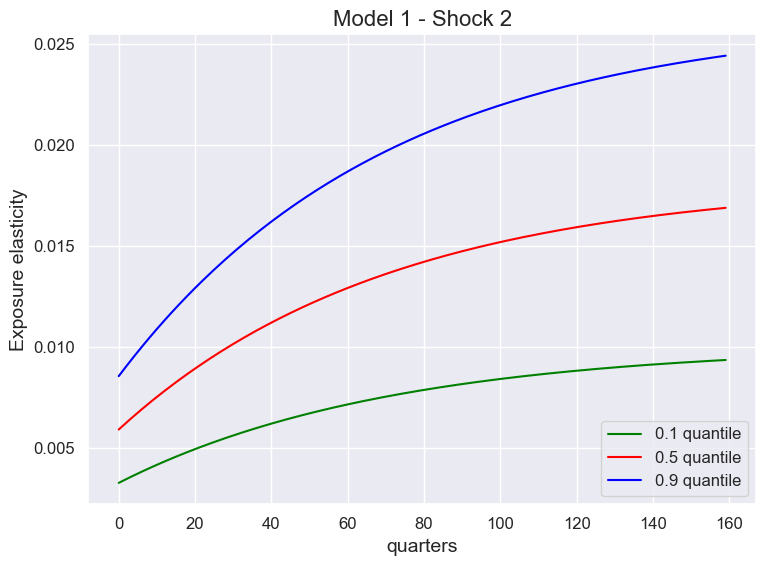

In [12]:
model_list=[
        models['gamma_1.001_rho_1.5']
    ]

plot_exposure_quantiles(
    model_list,
    quantile=[0.1, 0.5, 0.9],
    Mtgrowth_list = [compute_logMtM0(model) for model in model_list],
    T=160,
    num_shocks=1,
    time_unit='quarters',
    titles=None,
    title=None,
    save_path=None
)


It is also possible to compute price elasticities similarly:

In [13]:
def plot_price_elasticity(models, T, quantile, time_unit, title=None, ylimits=None, save_path=None):
    """
    Calculate and plot price elasticity for different models across subplots.
    
    Parameters:
    - models: List of result dictionaries to plot.
    - T: Integer, time horizon.
    - quantile: List of quantiles to calculate.
    - time_unit: String, label for x-axis time units (e.g., "quarters").
    - ylimits: Optional, list of y-axis limits for each subplot.
    - save_path: Optional, path to save the figure.
    """
    sns.set_style("darkgrid")
    num_models = len(models)

    # Initialize figure and axes for subplots
    fig, axes = plt.subplots(1, num_models, figsize=(8 * num_models, 8), squeeze=False)
    axes = axes.flatten()  # Ensure axes are flattened for easy iteration
    titles = [r'$\gamma=1$',r'$\gamma=4$',r'$\gamma=8$']

    for idx, res in enumerate(models):
        # Extract data from the current model
        X1_tp1 = res['X1_tp1']
        X2_tp1 = res['X2_tp1']
        gc_tp1 = res['gc_tp1']
        vmr_tp1 = res['vmr1_tp1'] + 0.5 * res['vmr2_tp1']
        logNtilde = res['log_N_tilde']

        # Calculate log_SDF
        β = get_parameter_value('beta', res['parameter_names'], res['args'])
        ρ = get_parameter_value('rho', res['parameter_names'], res['args'])
        log_SDF = np.log(β) - ρ * gc_tp1 + (ρ - 1) * vmr_tp1 + logNtilde

        # Calculate price elasticity for each shock
        price_elas_shock = [
            price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T, shock=1, percentile=p) for p in quantile
        ]

        # Prepare data for plotting
        index = ['T'] + [f'{q} quantile' for q in quantile]
        shock_data = pd.DataFrame(
            [np.arange(T), *[e.flatten() for e in price_elas_shock]],
            index=index
        ).T

        # Plot on the respective subplot
        ax = axes[idx]
        qt = [f'{q} quantile' for q in quantile]
        colors = ['green', 'red', 'blue']

        for j in range(len(quantile)):
            sns.lineplot(data=shock_data, x='T', y=qt[j], ax=ax, color=colors[j], label=qt[j])
        
        # Customize the subplot
        ax.set_xlabel(time_unit, fontsize=30)
        ax.set_ylabel('Price elasticity', fontsize=30)
        ax.set_title(titles[idx], fontsize=30)
        ax.tick_params(axis='y', labelsize=30)
        ax.tick_params(axis='x', labelsize=30)
        if idx == 0:
            ax.legend(fontsize=25)
        else:
            ax.legend().set_visible(False)

        # Set y-axis limits if provided
        # if ylimits and idx < len(ylimits):
        #     ax.set_ylim(ylimits[idx])
        if ylimits:
            ax.set_ylim(ylimits)
    plt.tight_layout()

    # Save and/or display the plot
    if save_path:
        plt.savefig(save_path, dpi=500)
    plt.show()


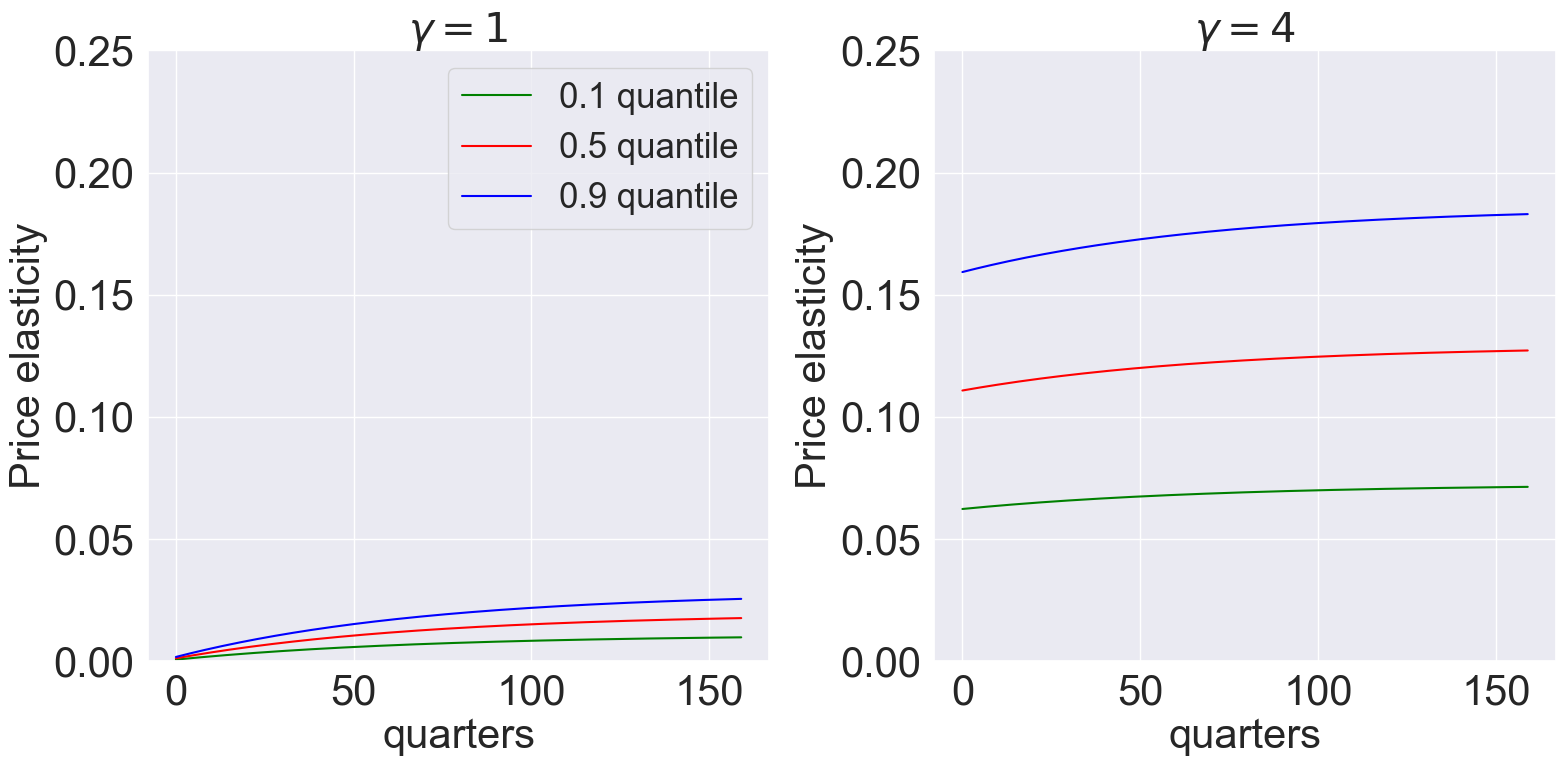

In [14]:
model_list = [models['gamma_1.001_rho_1.5'],models['gamma_8.001_rho_1.5']]
T = 160
plot_price_elasticity(model_list,T,[0.1,0.5,0.9],'quarters','0',[0,0.25],None)

<br>
<br>
<br>

# 3 Outputs

## 3.1 List of Outputs <a class="anchor" id="s3-1"></a>

We now examine the contents of `ModelSol`, which contains the attributes listed below. Each approximation is stored in a class `LinQuadVar`, which contains the coefficients for $X_{1,t}, X_{2,t}, X_{1,t}'X_{1,t}, W_{t+\epsilon}, W_{t+\epsilon}'W_{t+\epsilon}, X_{1,t}'W_{t+\epsilon}$ and the constant.


```{list-table}
* - Input
  - Type
  - Description
* - `JXn_t`
  - *LinQuadVar*
  - Approximation of jump and state variables at time $t$. Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. The variables are indexed in the order specified in Section 2. 
* - `Jn_t`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to jump variables.
* - `Xn_tp1`
  - *LinQuadVar*
  - Same as `JXn_t` but limited to state variables.
* - `JXn_t_tilde`
  - *LinQuadVar*
  - Same as `JXn_t` but using distorted measure. This variation is also available for `Jn_t` and `Xn_tp1`.
* - `util_sol`
  - *dict*
  - Dictionary containing solutions of the continuation values, including $\mu^0, \Upsilon_0^2, \Upsilon_1^2,$ and $\Upsilon_2^2$ etc.
* - `vmrn_tp1`
  - *LinQuadVar*
  - Approximation of continuation values $\widehat{V}^1_{t+\epsilon}-\widehat{R}^1_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `gcn_tp1`
  - *LinQuadVar*
  - Approximation of consumption growth $\widehat{C}_{t+\epsilon}-\widehat{C}_t$ . Replace `n` with `0,1,2` to get the zeroth, first and second-order contribution. Omit `n` to get the full approximation. 
* - `ss`
  - *dict*
  - Steady states for state and jump variables
* - `log_N_tilde`
  - *LinQuadVar*
  - Approximation for the log change of measure
```
For example, we can obtain the coefficients for the first-order contribution of $\log{C_t/K_t}$ in the following way, noting that `cmk_t` was listed as the first jump variable when we specified the equilibrum conditions.


In [64]:
## Log consumption over capital approximation results, shown in the LinQuadVar coefficients form
ModelSol['JX1_t'][0].coeffs

{'c': array([[-0.00000005]]),
 'x': array([[ 0.        ,  0.00056165, -0.        ]])}

We can also display the full second-order approximation of $\log{C_t/K_t}$ using the `disp` function, which renders a `LinQuadVar` object in LATEX form.

In [65]:
## Log consumption over capital approximation results, shown in the Latex analytical form
disp(ModelSol['JX_t'][0],'\\log\\frac{C_t}{K_t}') 

<IPython.core.display.Math object>

Another example:

In [66]:
## Log capital growth process second order approximation results
disp(ModelSol['X2_tp1'][0],'\\log\\frac{K_{t+\epsilon}^2}{K_t^2}') 

<IPython.core.display.Math object>

<br>

## 3.2 Simulate Variables <a class="anchor" id="s3-3"></a>
Given a series of shock processes, we can simulate the path of our state and jump variables using the `ModelSolution.simulate` method. Here, we simulate 400 periods of i.i.d standard multivariate normal shocks.

In [67]:
n_J, n_X, n_W = ModelSol['var_shape']
Ws = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 400)
JX_sim = ModelSol.simulate(Ws)

<br>
<br>

# 4 Using `LinQuadVar` in Computation <a class="anchor" id="s2"></a>

In the previous section, we saw how to use `uncertain_expansion` to approximate variables and store their coefficients as `LinQuadVar` objects. In this section, we explore how to manipulate `LinQuadVar` objects for different uses.

To aid our examples, we first extract the steady states for the state evolution processes from the previous model solution:

See [src/lin_quad.py](https://github.com/lphansen/RiskUncertaintyValue/blob/main/src/lin_quad.py) for source code of `LinQuadVar` definition.

In [68]:
ModelSol['ss'][[0,1,2]]

array([-4.12667104,  0.07606349,  0.60576715])

In [71]:
n_J, n_X, n_W = ModelSol['var_shape']
print(n_J, n_X, n_W)
X0_tp1 = LinQuadVar({'c':np.array([[ModelSol['ss'][0]],[ModelSol['ss'][1]],[ModelSol['ss'][2]]])}, shape = (n_X, n_X, n_W))

5 3 3


## 4.1 `LinQuadVar` Operations <a class="anchor" id="s4-1"></a>
We can sum multiple LinQuads together in two different ways. Here we demonstrate this with an example by summing the zeroth, first and second order contributions of our approximation for capital growth. 

In [72]:
gk_tp1 = X0_tp1[0] + ModelSol['X1_tp1'][0]  + 0.5 * ModelSol['X2_tp1'][0] 
disp(gk_tp1,'\\log\\frac{K_{t+\epsilon}}{K_t}') 

<IPython.core.display.Math object>

In the next example, we sum together the contributions for both capital growth and technology:

In [73]:
lq_sum([X0_tp1, ModelSol['X1_tp1'], 0.5 * ModelSol['X2_tp1']]).coeffs

{'c': array([[-4.12668054],
        [ 0.07606349],
        [ 0.5828862 ]]),
 'x': array([[-0.        ,  0.00999859,  0.        ],
        [ 0.        ,  0.986     ,  0.        ],
        [ 0.        ,  0.        ,  0.9515    ]]),
 'xw': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.00199981,  0.00086948,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.01239013,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.10696016]]),
 'x2': array([[-0.       ,  0.0049993,  0.       ],
        [ 0.       ,  0.493    ,  0.       ],
        [ 0.       ,  0.       ,  0.47575  ]]),
 'xx': array([[-0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     , 

## 4.2 `LinQuadVar` Split and Concat <a class="anchor" id="s4-2"></a>
`split` breaks multiple dimensional LinQuad into one-dimensional LinQuads, while `concat` does the inverse.

In [75]:
gk_tp1, Z_tp1, Y_tp1 = ModelSol['X1_tp1'].split()
concat([gk_tp1, Z_tp1, Y_tp1])

## 4.3 Evaluate a `LinQuadVar` <a class="anchor" id="s4-3"></a>
We can evaluate a LinQuad at specific state $(X_{t},W_{t+\epsilon})$ in time. As an example, we evaluate all 5 variables under steady state with a multivariate random normal shock.

In [76]:
x1 = np.zeros([n_X ,1])
x2 = np.zeros([n_X ,1])
x3 = np.zeros([n_X, 1])
w = np.random.multivariate_normal(np.zeros(n_W),np.eye(n_W),size = 1).T
ModelSol['JX_tp1'](*(x1,x2,w))

array([[ -4.12667002],
       [  0.07606348],
       [  0.60576726],
       [ -0.00018954],
       [  1.        ],
       [  0.00223285],
       [  0.00817758],
       [-11.99963929]])

## 4.4 Next period expression for `LinQuadVar` <a class="anchor" id="s4-4"></a>
`ModelSol` allows us to express a jump variable $J_t$ as a function of $t$ state and shock variables. Suppose we would like to compute its next period expression $J_{t+\epsilon}$ with shocks. The function `next_period` expresses $J_{t+\epsilon}$ in terms of $t$ state variables and $t+\epsilon$ shock variables. For example, we can express the $t+\epsilon$ expression for the first-order contribution to consumption over capital as:

In [48]:
ModelSol["X1_tp1"].coeffs

{'x': array([[-0.        ,  0.03710412, -0.        ,  0.00006824],
        [-0.        ,  0.944     , -0.        , -0.        ],
        [-0.        , -0.        ,  0.806     , -0.        ],
        [ 0.        , -0.0366626 ,  0.        , -0.10516689]]),
 'w': array([[ 0.00799924,  0.00347793, -0.        ],
        [-0.        ,  0.04956051, -0.        ],
        [-0.        , -0.        ,  0.42784065],
        [-0.00799924, -0.00347793, -0.        ]]),
 'c': array([[ 0.00111162],
        [ 0.        ],
        [ 0.        ],
        [-0.0012811 ]])}

In [77]:
cmk1_tp1 = next_period(ModelSol['J1_t'][0], ModelSol['X1_tp1'])
disp(cmk1_tp1, '\\log\\frac{C_{t+\epsilon}^1}{K_{t+\epsilon}^1}') 

<IPython.core.display.Math object>

In [78]:
cmk2_tp1 = next_period(ModelSol['J2_t'][0], ModelSol['X1_tp1'], ModelSol['X2_tp1'])
disp(cmk2_tp1, '\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}') 

<IPython.core.display.Math object>

## 4.6 Compute the Expectation of time $t+\epsilon$ `LinQuadVar` <a class="anchor" id="s4-6"></a>

Suppose the distribution of shocks has a constant mean and variance (not state dependent). Then, we can use the `E` function to compute the expectation of a time $t+\epsilon$ `LinQuadVar` as follows:


In [79]:
E_w = ModelSol['util_sol']['μ_0']
cov_w = np.eye(n_W)
E_ww = cal_E_ww(E_w, cov_w)
E_cmk2_tp1 = E(cmk2_tp1, E_w, E_ww)
disp(E_cmk2_tp1, '\mathbb{E}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>

Suppose the distribution of shock has a state-dependent mean and variance (implied by $\tilde{N}_{t+\epsilon}$ shown in the notes), we can use `E_N_tp1` and `N_tilde_measure` to compute the expectation of time $t+\epsilon$ `LinQuadVar`.

In [80]:
N_cm = N_tilde_measure(ModelSol['util_sol']['log_N_tilde'],(1,n_X,n_W))
E_cmk2_tp1_tilde = E_N_tp1(cmk2_tp1, N_cm)
disp(E_cmk2_tp1_tilde, '\mathbb{\\tilde{E}}[\\log\\frac{C_{t+\epsilon}^2}{K_{t+\epsilon}^2}|\mathfrak{F_t}]')

<IPython.core.display.Math object>